<div style="text-align: center;">
    <h1> <font style="bold"> Ejercicio de Optimización de Recomendaciones de Productos para Quilmes </font></h1>
    <h2><font style="bold">Test Técnico: Algoritmo de Optimización </font></h2>
    <h3><font style="bold">Abril Noguera</font></h3>
</div>

Este notebook se centra en el **reajuste de los objetivos de recomendación de productos** para Quilmes, asegurando que se cumplan ciertas restricciones comerciales y de ventas. El objetivo es encontrar un equilibrio óptimo entre las recomendaciones actuales y las restricciones impuestas, sin alterar el número total de recomendaciones.

## Carga de Información

In [245]:
# Importación de librerías
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import circlify
import scipy.stats as stats

In [246]:
df = pd.read_csv('dataAjuste.csv')

In [247]:
# Compruebo que tenga el total de los productos (116 productos únicos)
df['product_desc'].nunique() == 116

True

In [248]:
# Compruebo que tenga el total de las recomendaciones (6398 recomendaciones)
df['recomendaciones'].sum() == 6398

True

In [249]:
df.head()

,product_desc,customers_last_month,recomendaciones,brand_family,brand,pack,brand_segment_I,Error,Proporcion,Cumple_restricciones
0,1890-1 Lts-Bottle-RET,162,48,1890,1890,1 Lts-Bottle-RET,Value,-114.0,29.629630,No cumple
1,1890-1/2 Lts-Cans,75,52,1890,1890,1/2 Lts-Cans,Value,-23.0,69.333333,No cumple
2,27 Eazy-1/2 Lts-Cans,19,19,27 Eazy,27 Eazy,1/2 Lts-Cans,Super Premium,0.0,100.000000,Cumple
3,Andes Origen Criolla-1/2 Lts-Cans,5,5,Andes Origen,Andes Origen Criolla,1/2 Lts-Cans,Core +,0.0,100.000000,Cumple
4,Andes Origen Fresquita-1 Lts-Bottle-RET,37,38,Andes Origen,Andes Origen Fresquita,1 Lts-Bottle-RET,Core +,1.0,102.702703,Cumple


Se presenta una solución al problema de optimizar las recomendaciones de productos para Quilmes, asegurando que se cumplan ciertas restricciones clave planteadas por el equipo de ventas. El objetivo es ajustar las recomendaciones de manera que se mantenga la proporción adecuada de recomendaciones por cliente, se enfatice el segmento premium y se destaque un producto estrella. Y todo esto intentando variar lo menos posible las el objetivo provisto por el algoritmo de recomendación.

## Planteamiento del Problema:

La empresa se enfrenta a un desafío crítico relacionado con la asignación de recomendaciones a sus productos. El objetivo es optimizar la asignación de recomendaciones a 116 productos de manera que se cumplan ciertas restricciones y objetivos específicos.

### Restricciones y Objetivos

1. **Límites de Recomendaciones por Producto:**
   - Cada producto tiene un límite mínimo y máximo de recomendaciones permitidas en función de sus clientes del último mes.
   - Ningún producto debe recibir más del 200% de sus clientes del último mes en recomendaciones, ni menos del 75%.

2. **Proporción de Segmento Premium:**
   - El segmento premium de productos debe recibir al menos el 20% de todas las recomendaciones totales.

3. **Producto Estrella:**
   - El producto estrella "Brahma Dorada-1 Lts-Bottle-RET" debe recibir un mínimo de 200 recomendaciones.

4. **Conservación del Número Total de Recomendaciones:**
   - El número total de recomendaciones debe mantenerse constante a lo largo del proceso de asignación.

5. **Minimización de Desviaciones con respecto a las Recomendaciones Originales:**
   - Se busca minimizar las desviaciones con respecto a las recomendaciones originales tanto como sea posible, garantizando que la asignación se ajuste a todas las restricciones y objetivos anteriores.

El desafío radica en encontrar una asignación que minimice la diferencia entre las recomendaciones originales y las nuevas asignadas, cumpliendo al mismo tiempo con todas las restricciones y objetivos establecidos. El equilibrio en la distribución de recomendaciones es fundamental para lograr una solución óptima.


### Enfoque Propuesto

Para resolver este problema, adoptaremos un método de **Programación Lineal**. Este método matemático y analítico permite optimizar las recomendaciones dentro de un conjunto predefinido de restricciones lineales. Se minimizar una función objetivo, en este caso, la diferencia entre las recomendaciones originales y las nuevas asignadas, cumpliendo con todas las restricciones y objetivos establecidos.

**Variables de Decisión**: Sea $x_i$ la cantidad de recomendaciones que se le asignan al producto $i$.

**Función Objetivo**: Minimizar la diferencia entre las recomendaciones originales y las nuevas asignadas. Esto se puede expresar como:
$$
\text{Minimizar } \sum_{i=1}^{n} |x_i - \text{original}[i]|
$$

Donde $n$ es el número de productos.

**Restricciones**:

1. **Límites de Recomendaciones por Producto:**
   - $\text{min\_recom}_i \leq x_i \leq \text{max\_recom}_i$ para cada producto $i$.
   - $0.75 \times \text{clientes\_del\_mes}_i \leq x_i \leq 2.0 \times \text{clientes\_del\_mes}_i$ para cada producto $i$.

2. **Proporción de Segmento Premium:**
   - $\sum_{i \in \text{premium\_segment}} x_i \geq 0.20 \times \sum_{i=1}^{n} x_i$

3. **Producto Estrella:**
   - $x_{\text{producto\_estrella}} \geq 200$

4. **Conservación del Número Total de Recomendaciones:**
   - $\sum_{i=1}^{n} x_i = \text{total\_recom}$

Este es un problema de programación lineal que busca asignar recomendaciones a productos de manera óptima, minimizando las desviaciones con respecto a las recomendaciones originales y cumpliendo con todas las restricciones y objetivos establecidos.


## Implementación

### Definición de Variables

In [250]:
# Cantidad de productos
NUM_PRODUCTOS = len(df)

# Consumidores el último mes
customers_last_month = df['customers_last_month']

# Calcular el mínimo de recomendaciones para cada producto
MIN_RECOMENDACION = np.ceil(customers_last_month * 0.75).astype(int)

# Asegúrate de que el mínimo no sea menor que 1
MIN_RECOMENDACION = np.maximum(MIN_RECOMENDACION, 1).tolist()

# El mínimo para el producto estrella es de 200
producto_estrella = df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET'
INDICE_ESTRELLA = df.index[producto_estrella][0]
MIN_RECOMENDACION[INDICE_ESTRELLA] = 200

# Calcular el máximo de recomendaciones para cada producto
MAX_RECOMENDACION = np.ceil(customers_last_month * 2).astype(int).tolist()

# Calcula la suma total de recomendaciones que debe haber en cada generación
TOTAL_RECOMENDACION = sum(customers_last_month)

# Instancia el número de recomendaciones definidas originalmente
RECOMENDACION_ORIGINAL = df['recomendaciones'].tolist()

# Define los índices de los productos premium
SEGMENTO_PREMIUM = [i for i, s in enumerate(df['brand_segment_I'].tolist()) if s == 'Premium']

### Análisis de Factibilidad

Antes de comenzar, se analiza si es factible asignar las recomendaciones de acuerdo con las restricciones y, si lo es, se implementará la función para hacerlo.

- **Verificar si el total de recomendaciones mínimas no excede el total de recomendaciones actual**: Si la suma de los mínimos es mayor que el total esperado entonces no es posible satisfacer todas las restricciones.
- **Verificar si el total de recomendaciones máximas es al menos igual que el total de recomendaciones actual**: De la misma forma, si la suma de los máximos es menor que el total esperado entonces no es posible satisfacer todas las restricciones.
- **Verificar la factibilidad de asignar al menos el 20% del total de recomendaciones actual a los productos Premium**: Necesitamos asegurarnos de que los límites mínimo y máximo de los productos Premium permiten asignarles al menos el 20% del total de las recomendaciones.

In [251]:
# Calcular la suma de las recomendaciones mínimas y máximas
suma_min_recomendacion = sum(MIN_RECOMENDACION)
suma_max_recomendacion = sum(MAX_RECOMENDACION)

# Verificar si la suma de mínimos y máximos está dentro de los límites
factibilidad_min = suma_min_recomendacion <= TOTAL_RECOMENDACION
factibilidad_max = suma_max_recomendacion >= TOTAL_RECOMENDACION

if factibilidad_min and factibilidad_max:
    print('Factibilidad: OK')

Factibilidad: OK


In [252]:
# Calcular la suma de mínimos y máximos para productos Premium
min_premium = sum(MIN_RECOMENDACION[i] for i in SEGMENTO_PREMIUM)
max_premium = sum(MAX_RECOMENDACION[i] for i in SEGMENTO_PREMIUM)
total_premium_minimo = int(0.20 * TOTAL_RECOMENDACION)

# Verificar factibilidad de asignar el 20% a productos Premium
factibilidad_premium = min_premium <= total_premium_minimo and max_premium >= total_premium_minimo

if factibilidad_premium:
    print('Factibilidad Premium: OK')   

Factibilidad Premium: OK


Dado que todas las comprobaciones de factibilidad son verdaderas, podemos proceder a implementar el algoritmo de Programación Lineal.

### Programación Lineal

In [253]:
# Crear un problema de optimización lineal
lp_problem = pulp.LpProblem("Optimize_Recommendations", pulp.LpMinimize)

# Variables de decisión
n = len(RECOMENDACION_ORIGINAL)
x = [pulp.LpVariable(f"x_{i}", lowBound=MIN_RECOMENDACION[i], upBound=MAX_RECOMENDACION[i], cat=pulp.LpInteger) for i in range(n)]
# Limitación de mínimos y máximos para cumplir restricción de proporción

# Variables auxiliares para los valores absolutos
abs_diff = [pulp.LpVariable(f"abs_diff_{i}", lowBound=0, cat=pulp.LpInteger) for i in range(n)]

# Función objetivo: Minimizar la suma de los valores absolutos
lp_problem += pulp.lpSum(abs_diff)

# Restricciones para los valores absolutos
for i in range(n):
    lp_problem += abs_diff[i] >= x[i] - RECOMENDACION_ORIGINAL[i]
    lp_problem += abs_diff[i] >= RECOMENDACION_ORIGINAL[i] - x[i]

# Restricciones
lp_problem += pulp.lpSum([x[i] for i in SEGMENTO_PREMIUM]) >= 0.20 * pulp.lpSum(x) # Al menos 20% de productos Premium
lp_problem += x[INDICE_ESTRELLA] >= 200 # Producto foco con al menos 200 recomendaciones
lp_problem += pulp.lpSum(x) == TOTAL_RECOMENDACION # Total de recomendaciones

In [254]:
# Resolver el problema
lp_problem.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/anoguera/Documents/GitHub/MLAvanzado-Coursera/.conda/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/c8def473e81c4d54b25d08b4f4c90a81-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/c8def473e81c4d54b25d08b4f4c90a81-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 240 COLUMNS
At line 1518 RHS
At line 1754 BOUNDS
At line 2103 ENDATA
Problem MODEL has 235 rows, 232 columns and 697 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2212.4 - 0.00 seconds
Cgl0003I 0 fixed, 116 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 167 rows, 232 columns (232 integer (0 of which binary)) and 562 elements
Cutoff increment increased from 1e-05 to 0.

1

In [255]:
# Obtener las asignaciones óptimas
if lp_problem.status == pulp.LpStatusOptimal:
    solucion_optima = [x[i].varValue for i in range(n)]
    print("Asignación óptima de recomendaciones:", solucion_optima)
else:
    print("No se encontró una solución óptima.")

Asignación óptima de recomendaciones: [122.0, 57.0, 19.0, 5.0, 38.0, 108.0, 27.0, 12.0, 100.0, 58.0, 11.0, 30.0, 25.0, 153.0, 123.0, 13.0, 2.0, 53.0, 125.0, 8.0, 1.0, 3.0, 200.0, 114.0, 142.0, 318.0, 1.0, 478.0, 2.0, 154.0, 1.0, 3.0, 138.0, 189.0, 17.0, 95.0, 8.0, 51.0, 109.0, 136.0, 3.0, 22.0, 113.0, 16.0, 8.0, 83.0, 6.0, 54.0, 4.0, 1.0, 44.0, 1.0, 37.0, 11.0, 12.0, 3.0, 43.0, 23.0, 30.0, 3.0, 74.0, 6.0, 2.0, 27.0, 3.0, 7.0, 1.0, 2.0, 2.0, 6.0, 36.0, 34.0, 31.0, 13.0, 5.0, 46.0, 154.0, 11.0, 21.0, 256.0, 244.0, 108.0, 15.0, 3.0, 2.0, 60.0, 34.0, 123.0, 31.0, 75.0, 74.0, 4.0, 42.0, 338.0, 8.0, 4.0, 4.0, 32.0, 28.0, 96.0, 2.0, 8.0, 356.0, 240.0, 6.0, 8.0, 12.0, 6.0, 114.0, 6.0, 1.0, 5.0, 15.0, 15.0, 2.0, 12.0]


## Análisis de Resultados

### Verificación de Restricciones Cumplidas

Se verifica que todas las restricciones establecidas en el planteamiento del problema se cumplan con la solución óptima. Esto incluye:
- Límites de recomendaciones por producto.
- Proporción de recomendaciones en el segmento premium.
- Mínimo de recomendaciones para el producto estrella.
- Conservación del número total de recomendaciones.

In [256]:
def comprobar_restricciones(individual):
    # Calcular la proporción de recomendaciones sobre clientes
    proporciones = [(indiv / clm) * 100 for indiv, clm in zip(individual, customers_last_month)]

    # Verificar si se cumplen las restricciones de proporción
    cumple_proporcion = all((75 <= prop <= 200) for prop in proporciones)

    # Verificar la restricción del segmento Premium
    total_recomendaciones = sum(individual)
    recomendaciones_premium = sum(individual[i] for i in SEGMENTO_PREMIUM)
    porcentaje_premium = (recomendaciones_premium / total_recomendaciones) * 100 if total_recomendaciones else 0

    cumple_premium = porcentaje_premium >= 20

    # Verificar la restricción del producto estrella
    index_producto_estrella = df.index[producto_estrella][0]
    recomendaciones_producto_estrella = individual[index_producto_estrella]

    cumple_producto_estrella = recomendaciones_producto_estrella >= 200

    # Verificar que la cantidad de recomendaciones sea correcta
    cumple_cantidad = total_recomendaciones == TOTAL_RECOMENDACION

    # Crear un resumen de las restricciones
    restricciones_cumplidas = {
        'RESTRICCIONES TOTALES': cumple_proporcion and cumple_premium and cumple_producto_estrella and cumple_cantidad,
        'Proporción Recomendaciones/Cientes': cumple_proporcion,
        'Segmento Premium': cumple_premium,
        'Producto Estrella': cumple_producto_estrella,
        'Cantidad Total de Recomendaciones': cumple_cantidad
    }

    return restricciones_cumplidas

In [257]:
comprobar_restricciones(solucion_optima)

{'RESTRICCIONES TOTALES': True,
 'Proporción Recomendaciones/Cientes': True,
 'Segmento Premium': True,
 'Producto Estrella': True,
 'Cantidad Total de Recomendaciones': True}

La asignación de recomendaciones ha sido realizada de manera exitosa, cumpliendo con todas las restricciones y objetivos establecidos.

### Visualización de Resultados
En esta sección, se realiza un análisis detallado de los resultados obtenidos mediante la programación lineal. Exploraremos las diferencias entre la solución óptima y las recomendaciones originales, además de visualizar algunas características importantes de los productos.

In [258]:
df['Objetivo'] = solucion_optima

In [259]:
# Configuración para visualización de datos
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [260]:
color_barras = "#365CDF"
color_fondo = "#EEEFF0"
color_texto = "#000000"

#### Diferencias entre la Solución Óptima y las Recomendaciones Originales
Primero, examinemos las diferencias entre la asignación de recomendaciones realizada por el modelo de programación lineal y las recomendaciones originales proporcionadas. Para ello, calcularemos las desviaciones absolutas y porcentuales para cada producto.

In [276]:
# Calcular las desviaciones absolutas y porcentuales
df['Desviacion_Absoluta'] = abs(df['Objetivo'] - df['recomendaciones'])
df['Desviacion'] = df['Objetivo'] - df['recomendaciones']
df['Desviacion_Porcentual'] = (df['Desviacion_Absoluta'] / df['recomendaciones']) * 100

In [277]:
# Variación de recomendaciones
print('Variación de recomendaciones: ', df['Desviacion_Absoluta'].sum())
print('Porcentaje de variación de recomendaciones: ', df['Desviacion_Absoluta'].sum() / df['recomendaciones'].sum() * 100, '%')

Variación de recomendaciones:  2214.0
Porcentaje de variación de recomendaciones:  34.604563926226945 %


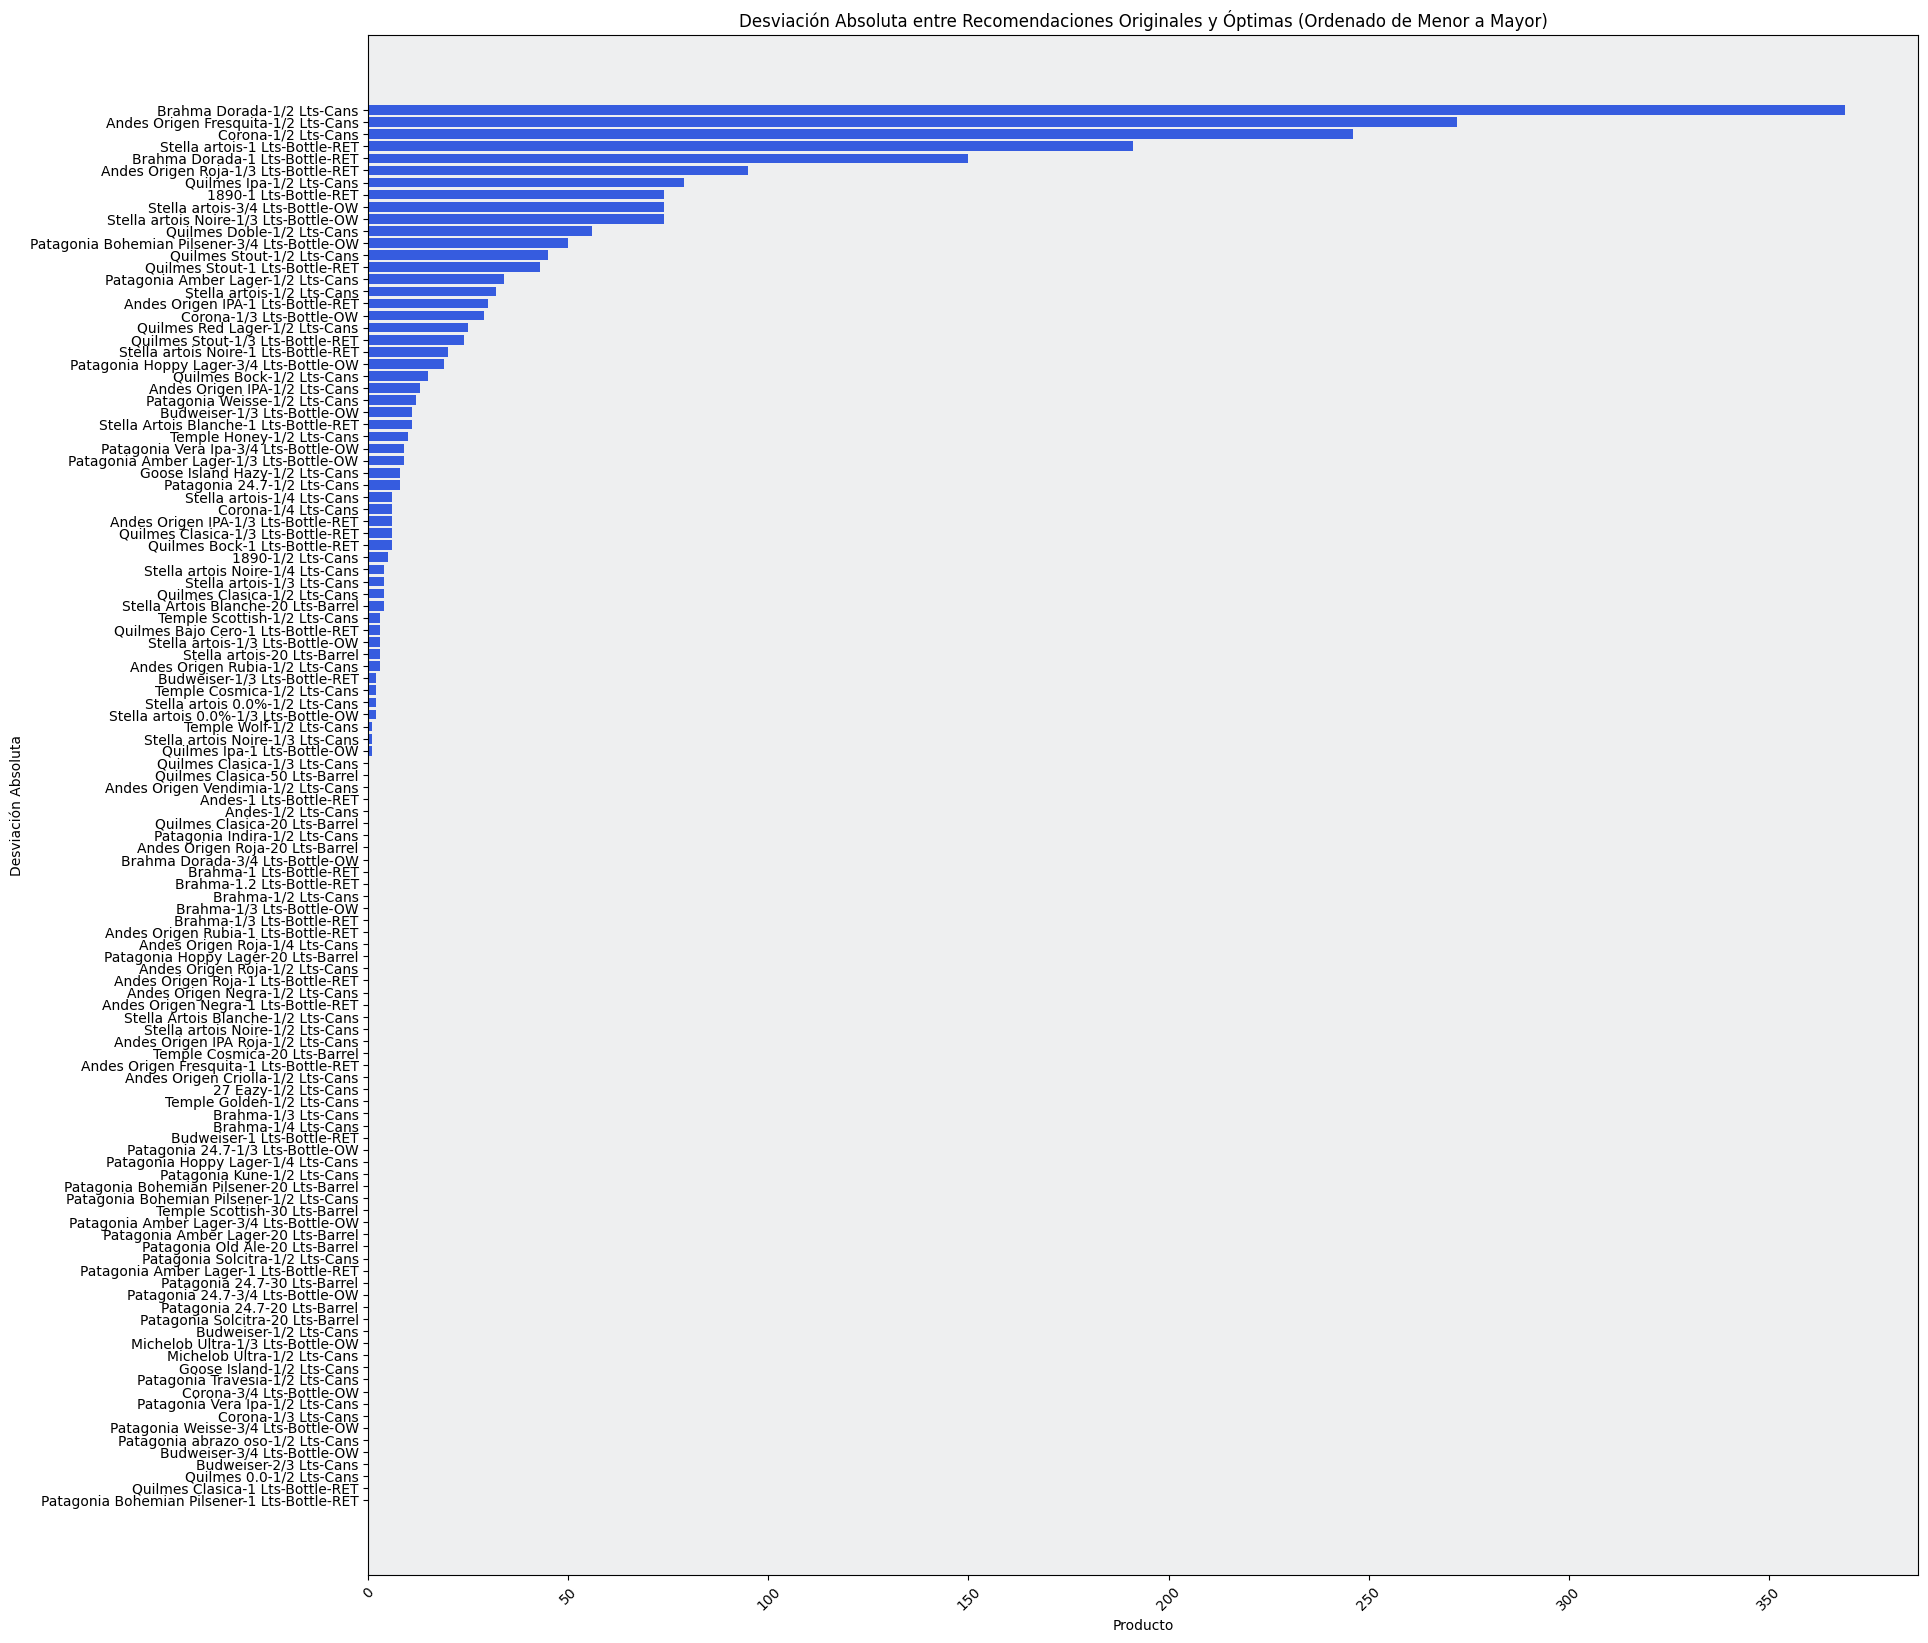

In [278]:
# Ordenar el DataFrame por desviación absoluta de menor a mayor
df_sorted = df.sort_values(by='Desviacion_Absoluta', ascending=True)

# Agregar colores para resaltar los productos que no cumplen con restricciones
colors = np.where(df_sorted['Cumple_restricciones'], color_barras, 'red')

# Crear gráficos de barras horizontales
plt.figure(figsize=(20, 20))

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

bars = plt.barh(df_sorted['product_desc'], df_sorted['Desviacion_Absoluta'], color=colors)
plt.xlabel('Producto')
plt.ylabel('Desviación Absoluta')
plt.title('Desviación Absoluta entre Recomendaciones Originales y Óptimas (Ordenado de Menor a Mayor)')

# Etiquetas para los productos que no cumplen con restricciones
for bar, cumple_restricciones in zip(bars, df_sorted['Cumple_restricciones']):
    if not cumple_restricciones:
        bar.set_alpha(0.7)  # Reducir la opacidad de los productos que no cumplen

plt.xticks(rotation=45)
plt.show()

- Solo se realizaron ajustes en aquellos productos que no cumplían con las restricciones originalmente.
- Es por eso que más de la mitad de los productos no tienen ajustes en las recomendaciones, esto para minimizar la variación entre la propuesta original y la solución optima.
- El mayor ajuste se vio en el producto estrella, se busco aumentar su cantidad de recomendaciones para darle el foco que requiere.

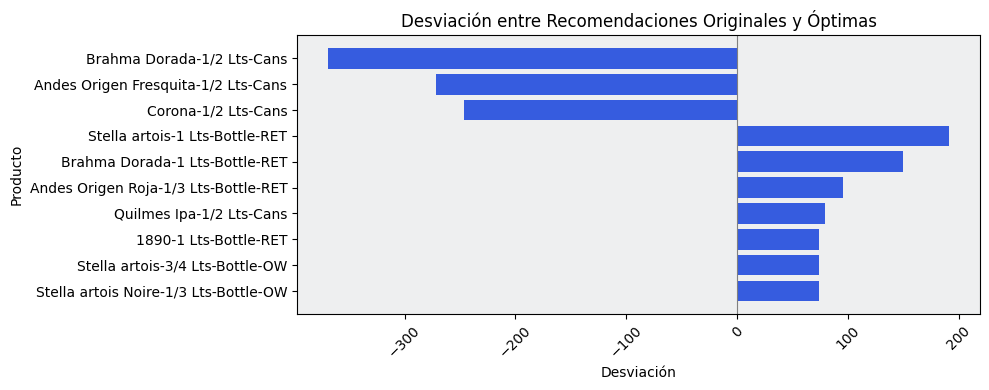

In [281]:
# Crear gráfico de barras horizontales
plt.figure(figsize=(10, 4))

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Filtro los que no tuvieron variación
df_filtrado = df_sorted[df_sorted['Desviacion'] != 0].tail(10)

# Crear las barras horizontales
bars = plt.barh(df_filtrado['product_desc'], df_filtrado['Desviacion'], color=color_barras)

# Etiquetas y título
plt.xlabel('Desviación')
plt.ylabel('Producto')
plt.title('Desviación entre Recomendaciones Originales y Óptimas')

# Resaltar los productos que no cumplen con restricciones
for bar, cumple in zip(bars, df_filtrado['Cumple_restricciones']):
    if not cumple:
        bar.set_alpha(0.7)  # Hacer las barras más transparentes

# Ajustar la posición del eje x para mostrar desviaciones negativas a la izquierda y positivas a la derecha
plt.axvline(x=0, color='grey', linewidth=0.8)

# Mejorar la legibilidad girando las etiquetas del eje x
plt.xticks(rotation=45)

# Ajustar el layout para evitar que las etiquetas se recorten
plt.tight_layout()

# Mostrar el gráfico
plt.show()


- Desviaciones Positivas y Negativas: El gráfico muestra tanto aumentos como reducciones en las recomendaciones óptimas en comparación con las originales.
- Mayoría de Aumentos: Hay una tendencia hacia desviaciones positivas, lo que sugiere que muchas recomendaciones originales eran inferiores a las óptimas.
- Desviaciones Significativas: Algunos productos muestran desviaciones grandes, indicando una posible subestimación importante en las recomendaciones iniciales.
- Cercanía a lo Óptimo: Los productos con barras cortas cerca de la línea cero tenían recomendaciones iniciales cercanas a las óptimas.
- Asimetría en las Recomendaciones: No hay un patrón claro que indique un sesgo consistente hacia sobreestimaciones o subestimaciones en las recomendaciones.
- Ajustes Importantes: Los datos reflejan que se han realizado ajustes considerables para alinear las recomendaciones con los objetivos óptimos.
- Revisión de Estrategias de Recomendación: Las grandes desviaciones para ciertos productos podrían señalar la necesidad de revisar las estrategias de recomendación actuales.

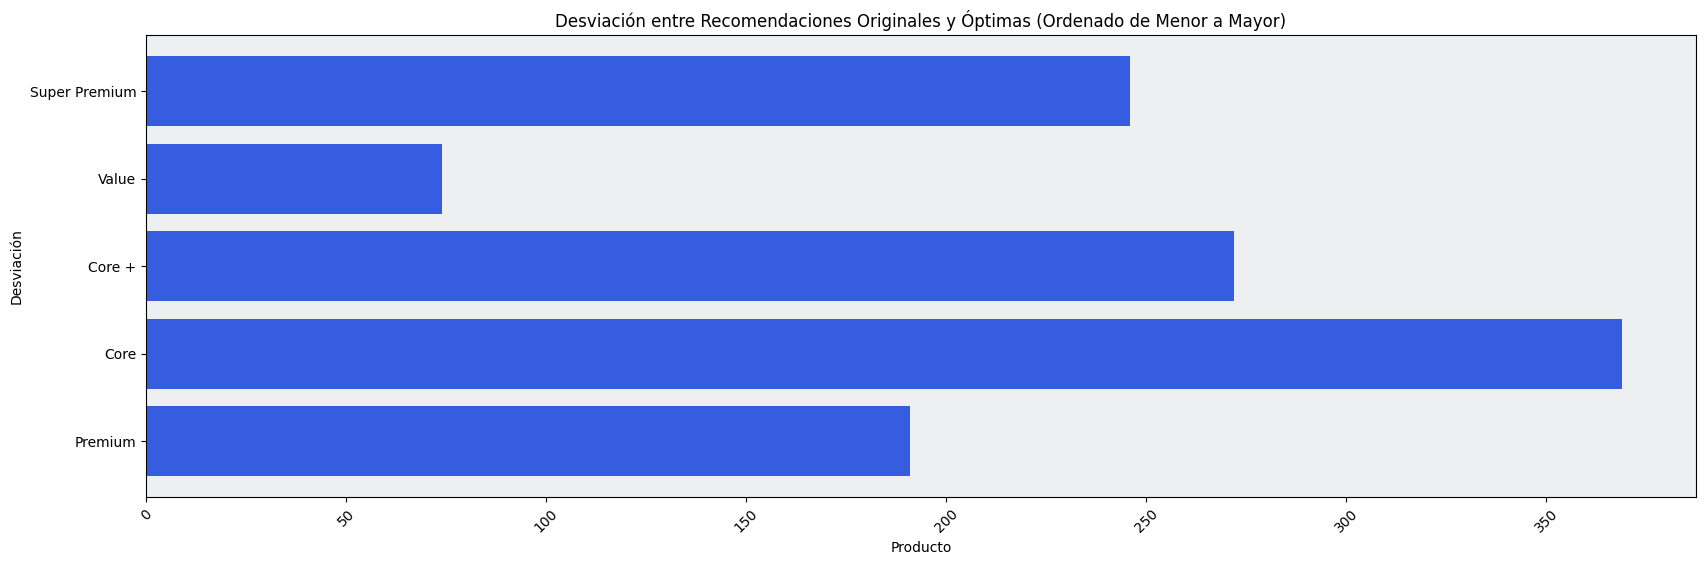

In [81]:
# Ordenar el DataFrame por desviación absoluta de menor a mayor
df_sorted = df.sort_values(by='Desviacion', ascending=True)

# Crear gráficos de barras horizontales
plt.figure(figsize=(20, 6))

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

bars = plt.barh(df_sorted['brand_segment_I'], df_sorted['Desviacion_Absoluta'], color=color_barras)
plt.xlabel('Producto')
plt.ylabel('Desviación')
plt.title('Desviación entre Recomendaciones Originales y Óptimas (Ordenado de Menor a Mayor)')

# Etiquetas para los productos que no cumplen con restricciones
for bar, cumple_restricciones in zip(bars, df_sorted['Cumple_restricciones']):
    if not cumple_restricciones:
        bar.set_alpha(0.7)  # Reducir la opacidad de los productos que no cumplen

plt.xticks(rotation=45)
plt.show()

- Desviaciones en Segmentos de Productos: Cada segmento de producto presenta una desviación diferente entre las recomendaciones originales y las óptimas.
- Mayor Desviación en 'Core': El segmento 'Core' muestra la desviación más significativa, lo que indica que las recomendaciones originales para este segmento estaban muy lejos de las óptimas.
- Desviaciones Menores en 'Super Premium' y 'Value': Los segmentos 'Super Premium' y 'Value' tienen las menores desviaciones, sugiriendo que las recomendaciones originales para estos productos eran más precisas.
- Desviación Moderada en 'Premium' y 'Core+': Los segmentos 'Premium' y 'Core +' muestran desviaciones moderadas, lo que significa que las recomendaciones originales necesitaban ajustes pero no tan extensos como en el segmento 'Core'.
- Posible Enfoque de Optimización: Los datos pueden sugerir que el modelo de optimización puso más énfasis en ajustar las recomendaciones en el segmento 'Core', quizás debido a su importancia o volumen en el negocio.
- Implicaciones Estratégicas: Las diferencias en las desviaciones podrían indicar que los segmentos de productos varían en cómo deben ser manejados o en la precisión de los datos utilizados para las recomendaciones originales.

/var/folders/6c/17qbm4nd5318hd4bcrx68wjh0000gn/T/ipykernel_99278/311901876.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(cum_values.iloc[0][i] + value/2, index, f"{value:.1%}", va='center', ha='center')


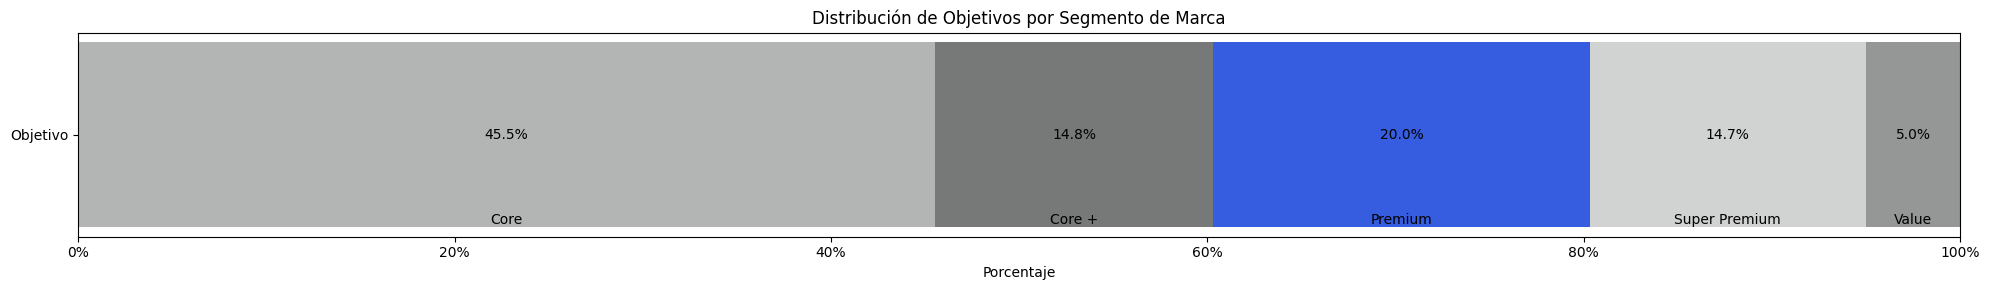

In [239]:
# Convertir a datos de porcentaje
df_percent = df.pivot_table(index='brand_segment_I', values='Objetivo', aggfunc='sum')
df_percent = df_percent.divide(df_percent.sum(axis=0), axis=1)

# Trasponer el DataFrame para tener segmentos como columnas
df_percent = df_percent.T

# Calcular el 'bottom' para las barras
cum_values = df_percent.cumsum(axis=1).shift(axis=1).fillna(0)

# Iniciar la figura de Matplotlib
fig, ax = plt.subplots(figsize=(20, 3))

# Colores para cada segmento
colors = ['#b3b4b4', '#777878', color_barras, '#d1d2d2', '#959696']

# Crear las barras apiladas horizontalmente
for i, (column_name, values) in enumerate(df_percent.items()):
    bars = ax.barh(df_percent.index, values, left=cum_values[column_name], color=colors[i])

    # Añadir las etiquetas dentro de cada barra
    for bar in bars:
        width = bar.get_width()
        label_x_pos = bar.get_x() + width / 2
        if width > 0.05:  # Ajusta este valor según sea necesario para tu conjunto de datos
            ax.text(label_x_pos, bar.get_y(), column_name, ha='center', va='bottom')

# Añadir los porcentajes encima de las barras
for i, (column_name, values) in enumerate(df_percent.items()):
    for index, value in enumerate(values):
        if value > 0.05:  # Ajusta este valor según sea necesario
            ax.text(cum_values.iloc[0][i] + value/2, index, f"{value:.1%}", va='center', ha='center')

# Establecer títulos y etiquetas
ax.set_xlabel('Porcentaje')
ax.set_title('Distribución de Objetivos por Segmento de Marca')

# Cambiar el formato de x a porcentaje
ax.xaxis.set_major_formatter(PercentFormatter(1))

plt.xlim(0,1)

# Ajustar el layout y mostrar la gráfica
plt.tight_layout()
plt.show()

#### Visualización de Características de los Productos
Además de las desviaciones, también es importante visualizar algunas características clave de los productos que pueden haber influido en las recomendaciones óptimas. A continuación, exploraremos estas características y su relación con las recomendaciones asignadas.

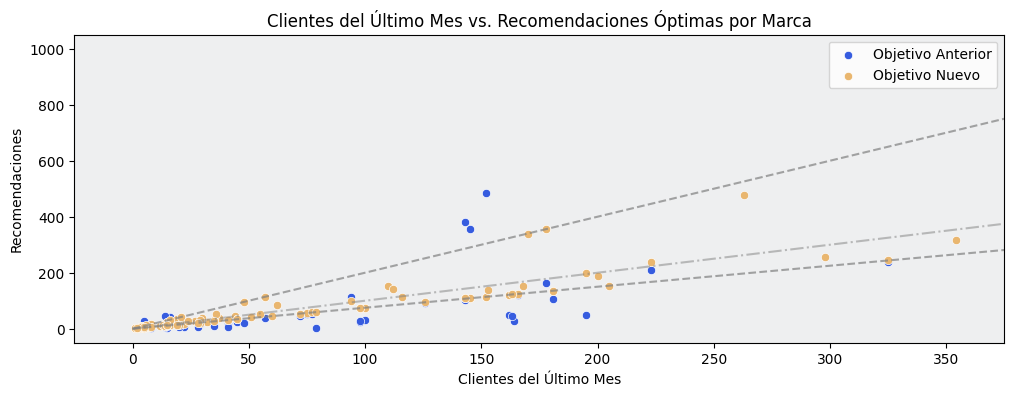

In [234]:
# Crear gráficos de dispersión para algunas características vs. recomendaciones
plt.figure(figsize=(12, 4))
sns.scatterplot(data=df,x='customers_last_month', y='recomendaciones', color=color_barras, label='Objetivo Anterior')
sns.scatterplot(data=df, x='customers_last_month', y='Objetivo', color='#E9B66F', label='Objetivo Nuevo')

# Establecer el color del fondo
plt.gca().set_facecolor(color_fondo)

# Eliminar la cuadrícula
plt.grid(False)

# Añadir líneas punteadas
x = np.linspace(0, 500, 100)  # Crear un rango de valores para x
plt.plot(x, x, linestyle='-.', color='grey', label='y = x', alpha=0.5)  # Línea para y = x
plt.plot(x, 0.75 * x, linestyle='--', color='grey', label='y = 0.75x', alpha=0.7)  # Línea para y = 0.75x
plt.plot(x, 2 * x, linestyle='--', color='grey', label='y = 2x', alpha=0.7)  # Línea para y = 2x

plt.xlim(-25,375)

plt.xlabel('Clientes del Último Mes')
plt.ylabel('Recomendaciones')
plt.title('Clientes del Último Mes vs. Recomendaciones Óptimas por Marca')
plt.show()

- El objetivo nuevo tiende a estar más alineado con la cantidad de clientes del último mes en comparación con el objetivo anterior.
- La solución óptima parece ofrecer una relación más consistente entre el número de clientes y las recomendaciones.
- Los puntos del objetivo nuevo parecen seguir una tendencia que sugiere una correlación más directa entre los clientes y las recomendaciones, lo que podría indicar que los objetivos se han ajustado para reflejar mejor la realidad del mercado o la capacidad de producción.
- Hay menos variabilidad en las recomendaciones con respecto al número de clientes, lo que puede ayudar a una planificación más precisa y predecible.

In [235]:
# Tamaño producto estrella
df[df['product_desc'] == 'Brahma Dorada-1 Lts-Bottle-RET']['Objetivo'].sum()

200.0

**Análisis de Normalidad del Error:**

In [83]:
# Error entre cantidad de recomendaciones y clientes del último mes
df['Error Nuevo'] = df['Objetivo'] - df['customers_last_month']

In [84]:
df['Error Nuevo'].describe()

count    116.000000
mean       0.000000
std       35.931335
min      -81.000000
25%       -8.500000
50%        0.000000
75%        1.000000
max      215.000000
Name: Error Nuevo, dtype: float64

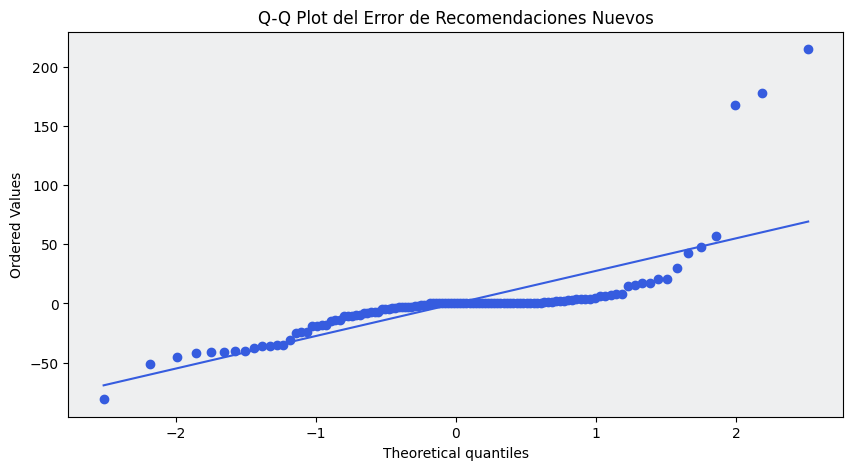

In [85]:
# Q-Q plot para verificar la normalidad de la variable 'Error'
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
stats.probplot(df['Error Nuevo'], dist="norm", plot=ax)
ax.get_lines()[0].set_color(color_barras)  
ax.get_lines()[1].set_color(color_barras)  
ax.title.set_text('Q-Q Plot del Error de Recomendaciones Nuevos')

# Establecer el color del fondo
ax.set_facecolor(color_fondo)

# Eliminar la cuadricula
ax.grid(False)

plt.show()

- Errores moderados siguen una distribución normal, indicando que las recomendaciones son generalmente precisas.
- Sobreestimaciones extremas presentes, señalando a valores atípicos en las recomendaciones.
- Sesgo en la cola derecha puede reflejar las restricciones operativas o comerciales del área de ventas.

Mientras que el modelo de recomendaciones funciona bien para la mayoría de los casos (siguiendo una distribución normal), hay casos extremos, especialmente de sobreestimación, que podrían beneficiarse de una revisión para alinear las recomendaciones con las expectativas teóricas y prácticas.

In [86]:
# Procesamiento de la Variable Marca
df.loc[df['brand_family'] == 'Quilmes Variedades ', 'brand_family'] = 'Quilmes'
df.loc[df['brand_family'] == 'Andes', 'brand_family'] = 'Andes Origen'
df.loc[df['brand'] == 'Andes', 'brand'] = 'Andes Origen'

# Preparar los datos para el gráfico de Circle Packing
data = df.groupby(['brand_family', 'brand']).sum('Objetivo')

# Agrupar y sumar las frecuencias por brand_family y producto
grouped_data = data.groupby(['brand_family', 'brand'])['Objetivo'].sum().reset_index()

# Crear una estructura de datos para almacenar la jerarquía
result = [{'id': 'Cervezas', 'datum': grouped_data['Objetivo'].sum(), 'children': []}]

# Iterar a través de las marcas y crear la jerarquía
for marca in grouped_data['brand_family'].unique():
    marca_data = grouped_data[grouped_data['brand_family'] == marca]
    marca_entry = {'id': marca, 'datum': marca_data['Objetivo'].sum(), 'children': []}

    for _, row in marca_data.iterrows():
        producto_entry = {'id': row['brand'], 'datum': row['Objetivo']}
        marca_entry['children'].append(producto_entry)

    result[0]['children'].append(marca_entry)

# Mostrar el resultado
print(result)

[{'id': 'Cervezas', 'datum': 6636.0, 'children': [{'id': '1890', 'datum': 179.0, 'children': [{'id': '1890', 'datum': 179.0}]}, {'id': '27 Eazy', 'datum': 19.0, 'children': [{'id': '27 Eazy', 'datum': 19.0}]}, {'id': 'Andes Origen', 'datum': 895.0, 'children': [{'id': 'Andes Origen', 'datum': 4.0}, {'id': 'Andes Origen Criolla', 'datum': 5.0}, {'id': 'Andes Origen Fresquita', 'datum': 146.0}, {'id': 'Andes Origen IPA', 'datum': 170.0}, {'id': 'Andes Origen IPA Roja', 'datum': 27.0}, {'id': 'Andes Origen Negra', 'datum': 41.0}, {'id': 'Andes Origen Roja', 'datum': 316.0}, {'id': 'Andes Origen Rubia', 'datum': 178.0}, {'id': 'Andes Origen Vendimia', 'datum': 8.0}]}, {'id': 'Brahma', 'datum': 1413.0, 'children': [{'id': 'Brahma', 'datum': 957.0}, {'id': 'Brahma Dorada', 'datum': 456.0}]}, {'id': 'Budweiser', 'datum': 498.0, 'children': [{'id': 'Budweiser', 'datum': 498.0}]}, {'id': 'Corona', 'datum': 383.0, 'children': [{'id': 'Corona', 'datum': 383.0}]}, {'id': 'Goose Island', 'datum': 2

In [87]:
# Computar las posiciones de los círculos
circles = circlify.circlify(
    result, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

In [88]:
# Definición de marcas conocidas
marcas_conocidas = df['brand_family'].unique()
marcas_conocidas = sorted(marcas_conocidas, key=len, reverse=True)

# Función para identificar la marca y el producto
def identificar_producto(nombre):
    for marca in marcas_conocidas:
        if nombre.startswith(marca):
            # El resto de la cadena después del nombre de la marca sería el producto
            producto = nombre[len(marca):].strip()
            return marca, producto if producto else 'Clasica'
    return 'desconocida', nombre

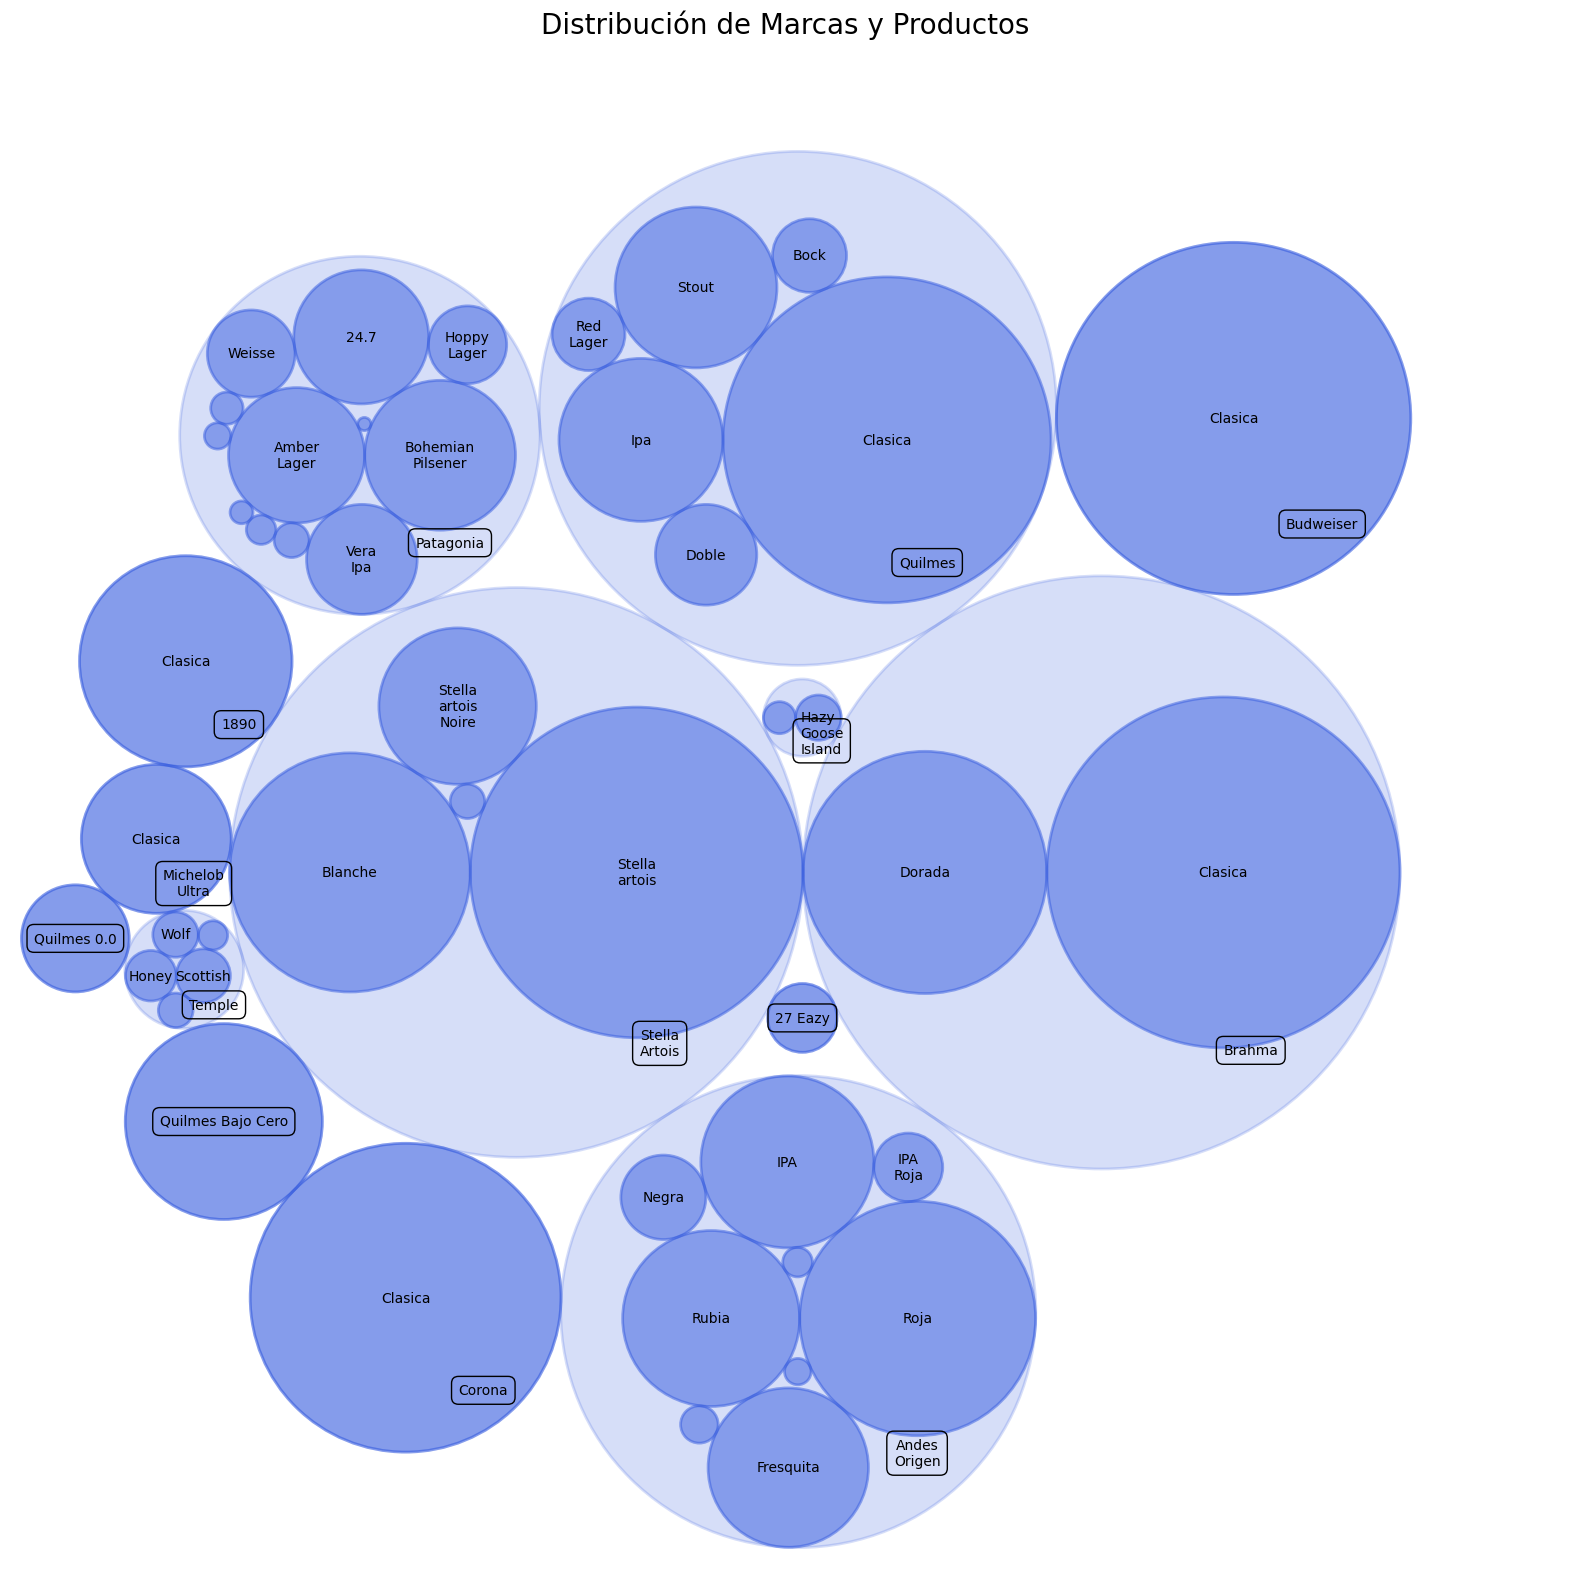

In [89]:
# Crear la figura
fig, ax = plt.subplots(figsize=(20,20))

# Título
ax.set_title('Distribución de Marcas y Productos', fontsize=20)

# Eliminar ejes
ax.axis('off')

# Encontrar limites en los ejes
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Filtra los productos con frecuencia baja frecuencia o poca diversidad.
productos_filtrados = df[df['Objetivo'] >= 10]
marcas_filtradas = df.groupby('brand_family').size().reset_index(name='Objetivo')
marcas_filtradas = marcas_filtradas.loc[marcas_filtradas['Objetivo'] == 1,'brand_family'].to_list()

# Imprimir círculos de mayor nivel
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=color_barras))

# Imprimir círculos y etiquetas de productos con frecuencia mayor o igual a 10
for circle in circles:
    if circle.level != 3:
        continue
    x, y, r = circle
    parent, label = identificar_producto(circle.ex["id"])
    ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2, color=color_barras))

    # Verifica si el producto está en la lista de productos filtrados
    if (circle.ex["id"] in productos_filtrados['brand'].values) & (parent not in marcas_filtradas):
        if ' ' in label:
            label = label.replace(' ', '\n')
        plt.annotate(label, (x, y),va='center', ha='center', color=color_texto)


# Imprimir etiquetas para círculos de marcas
for circle in circles:
    if circle.level != 2:
      continue
    x, y, r = circle
    label = circle.ex["id"]
    if label in marcas_filtradas:
        plt.annotate(label, (x, y) ,va='center', ha='center', bbox=dict(facecolor='none', edgecolor=color_texto, boxstyle='round', pad=0.5))
    else:
        if ' ' in label:
                label = label.replace(' ', '\n')
        plt.annotate(label, (x + 0.5 * r , y - 0.6 * r ) ,va='center', ha='center', bbox=dict(facecolor='none', edgecolor=color_texto, boxstyle='round', pad=0.5))


### Conclusiones

- El análisis y la solución óptima obtenida indican que las recomendaciones están ahora en línea con las restricciones y objetivos propuestos por el equipo de ventas. Esto sugiere que el modelo ha sido efectivo en integrar los requisitos comerciales en la estrategia de optimización, asegurando que las soluciones propuestas sean viables y aplicables en un contexto de negocios real.
- La actualización de los objetivos ha resultado en un alineamiento más estrecho entre las recomendaciones y la cantidad de clientes, lo cual es indicativo de una mejora en la precisión del modelo.
- La solución óptima muestra una relación más coherente y menos variabilidad, lo que sugiere una mejora en la predictibilidad y potencialmente en la eficiencia del modelo.
- La tendencia observada en los puntos del nuevo objetivo indica una correlación más directa y posiblemente una formulación de objetivo más realista en comparación con el anterior.

### Posibles Mejoras

- **Validación con datos históricos**: Utilizar datos históricos para validar si las recomendaciones óptimas corresponden a mejores resultados comerciales reales, y ajustar el modelo en consecuencia.
- **Incorporar otros factores**: Considerar la inclusión de más variables que puedan influir en las recomendaciones, como tendencias del mercado, factores estacionales, o comportamientos de consumo cambiantes.
- **Optimización multiobjetivo**: Si existen múltiples objetivos (como maximizar la satisfacción del cliente y minimizar los costos), considerar el uso de técnicas de optimización multiobjetivo para equilibrar mejor estos factores.
- **Automatización del proceso de ajuste**: Desarrollar un proceso automatizado para ajustar dinámicamente los objetivos y restricciones en respuesta a los cambios en tiempo real en los datos de entrada y condiciones del mercado.

### Preparación de la Información

Se prepara la información para obtener el resultado final, una tabla con los resultados a nivel producto con los nuevos objetivos calculados.

In [108]:
df['recomendaciones'] = df['recomendaciones'].astype(int)
df['Objetivo'] = df['Objetivo'].astype(int)

In [109]:
resultado = df[['product_desc','recomendaciones', 'Objetivo']]

In [110]:
resultado = resultado.rename(columns={'recomendaciones': 'Objetivo Anterior', 'Objetivo': 'Objetivo Nuevo'})

In [111]:
resultado.head()

,product_desc,Objetivo Anterior,Objetivo Nuevo
0,1890-1 Lts-Bottle-RET,48,122
1,1890-1/2 Lts-Cans,52,57
2,27 Eazy-1/2 Lts-Cans,19,19
3,Andes Origen Criolla-1/2 Lts-Cans,5,5
4,Andes Origen Fresquita-1 Lts-Bottle-RET,38,38


In [112]:
resultado.to_csv('resultado.csv', index=False)